This Notebook imports and explores the training dataset for the Kaggle SF Crime problem
https://www.kaggle.com/c/sf-crime

Current Exploration:
- Count unique values for each variable
- View most common values

Future Exploration:
- XY plot of lat/long w. circles to indicate number of crimes (and colors to show category?)
- Time series plots to see how category use changes over time



Interesting Points:
- Most crime on Friday, then Wednesday. Least on Sunday.
- X and Y latitude have same number of distinct values. Seem to be somehow linked to locations
  since, despite there being a lots of sig fig, they still can be frequency counted
- 800 Block of BRYANT ST has 4x+ more data points than anyplace else. Seems to link w/ most freq X and Y
- "Other Offenses" are common
- The dates with the most crime are new years day. Also the first of months.
- Note: Strange max value of Y = 90 for 67 values. These appear to be in Chicago, but the data has addresses in SF.


In [27]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import csv
import datetime

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report


In [40]:
data = pd.read_csv("train.csv")
#data = data[data.Category=='LARCENY/THEFT']
#data = pd.read_csv("train.csv")
data.shape

(878049, 9)

In [29]:
# Clean some variables, parse out dates for time-series analysis
data['Dates'] = pd.to_datetime(data['Dates'])
data['Year'] = data.Dates.dt.year
data['Month'] = data.Dates.dt.month
data['Day'] = data.Dates.dt.day
data['Date'] = data.Dates.dt.date
data['Hour'] = data.Dates.dt.hour
data['DayOfYear'] = data.Dates.dt.dayofyear
data.dtypes


Dates         datetime64[ns]
Category              object
Descript              object
DayOfWeek             object
PdDistrict            object
Resolution            object
Address               object
X                    float64
Y                    float64
Year                   int64
Month                  int64
Day                    int64
Date                  object
Hour                   int64
DayOfYear              int64
dtype: object

In [30]:
# Count distinct for each variable:
print "There are a total of {:,}, values.".format(len(data))

for var, series in data.iteritems():
    print "There are a total of {:,} {}.".format(len(series.value_counts()), var)


There are a total of 174,900, values.
There are a total of 114,134 Dates.
There are a total of 1 Category.
There are a total of 62 Descript.
There are a total of 7 DayOfWeek.
There are a total of 10 PdDistrict.
There are a total of 16 Resolution.
There are a total of 17,535 Address.
There are a total of 23,990 X.
There are a total of 23,990 Y.
There are a total of 13 Year.
There are a total of 12 Month.
There are a total of 31 Day.
There are a total of 2,248 Date.
There are a total of 24 Hour.
There are a total of 338 DayOfYear.


In [44]:
# View All of Categories, PdDistrict, Resolution, DayOfWeek
variables = ["Category", "PdDistrict", "Resolution", "DayOfWeek","Year","Month","Day","Hour"]
x = data["Category"].value_counts()/len(data)
for col in variables:
    print "-------------------------------------------------------------------------"
    print "There are a total of {:,} distinct {} values, as follows: ".format(len(data[col].value_counts()), col)
    print data[col].value_counts()/len(data)
    print


-------------------------------------------------------------------------
There are a total of 39 distinct Category values, as follows: 
LARCENY/THEFT                  0.199192
OTHER OFFENSES                 0.143707
NON-CRIMINAL                   0.105124
ASSAULT                        0.087553
DRUG/NARCOTIC                  0.061467
VEHICLE THEFT                  0.061251
VANDALISM                      0.050937
WARRANTS                       0.048077
BURGLARY                       0.041860
SUSPICIOUS OCC                 0.035777
MISSING PERSON                 0.029599
ROBBERY                        0.026194
FRAUD                          0.018996
FORGERY/COUNTERFEITING         0.012082
SECONDARY CODES                0.011372
WEAPON LAWS                    0.009743
PROSTITUTION                   0.008523
TRESPASS                       0.008343
STOLEN PROPERTY                0.005171
SEX OFFENSES FORCIBLE          0.004997
DISORDERLY CONDUCT             0.004920
DRUNKENNESS            

KeyError: 'Year'

In [32]:
# View Top 15 of Dates, Descript, Address, X, Y
variables = ["Dates", "Descript", "Address", "X", "Y", "Date", "DayOfYear"]
for col in variables:
    print "-------------------------------------------------------------------------"
    print "There are a total of {:,} distinct {} values. The top 15 are: ".format(len(data[col].value_counts()), col)
    print data[col].value_counts().head(15)
    print


-------------------------------------------------------------------------
There are a total of 114,134 distinct Dates values. The top 15 are: 
2011-01-01 00:01:00    17
2008-11-01 00:01:00    12
2015-02-03 19:00:00    12
2014-06-28 15:00:00    12
2013-11-01 00:01:00    12
2013-08-11 13:00:00    11
2012-11-03 19:00:00    11
2006-12-15 17:00:00    11
2006-01-14 23:00:00    11
2014-12-12 20:00:00    11
2015-01-23 21:00:00    11
2015-01-19 16:00:00    10
2014-12-12 21:00:00    10
2013-08-09 19:00:00    10
2006-08-26 23:00:00    10
dtype: int64

-------------------------------------------------------------------------
There are a total of 62 distinct Descript values. The top 15 are: 
GRAND THEFT FROM LOCKED AUTO           60022
PETTY THEFT FROM LOCKED AUTO           19771
PETTY THEFT OF PROPERTY                16196
GRAND THEFT OF PROPERTY                11010
PETTY THEFT FROM A BUILDING            10029
PETTY THEFT SHOPLIFTING                 9571
GRAND THEFT FROM A BUILDING             95

In [33]:
# Describe floats
print data.describe()

# Note - strange max value of Y = 90 degrees

                   X              Y           Year          Month  \
count  174900.000000  174900.000000  174900.000000  174900.000000   
mean     -122.422446      37.777946    2009.169588       6.513602   
std         0.030663       0.484136       3.697005       3.428427   
min      -122.513642      37.707968    2003.000000       1.000000   
25%      -122.432915      37.764115    2006.000000       4.000000   
50%      -122.416294      37.779441    2009.000000       7.000000   
75%      -122.405927      37.787018    2013.000000      10.000000   
max      -120.500000      90.000000    2015.000000      12.000000   

                 Day           Hour      DayOfYear  
count  174900.000000  174900.000000  174900.000000  
mean       15.841921      14.414265     182.941098  
std         8.713197       6.153903     104.934235  
min         1.000000       0.000000       1.000000  
25%         8.000000      11.000000      92.000000  
50%        16.000000      16.000000     182.000000  
75%    

In [34]:
outlier = data[data.Y == 90]
print "There are {} outliers where Y == 90. These appear to be in Chicago, but the data has addresses in SF.".format(len(outlier))
print "We have saved the outliers separately, then will remove them from the data for plotting."
# The line below prints a table with all outliers. It looks cleaner if we do not use "print" because Pandas has
# nice formatting:
# outlier

data_clean = data[data.Y != 90]


There are 15 outliers where Y == 90. These appear to be in Chicago, but the data has addresses in SF.
We have saved the outliers separately, then will remove them from the data for plotting.


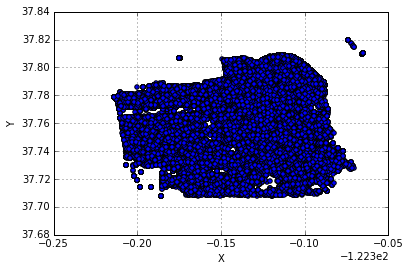

In [35]:
# Plot coordinates - basic plot
data_clean.plot(kind='scatter', x='X', y='Y')

The number of observations to plot is condensed from 174,885 to 23,989.


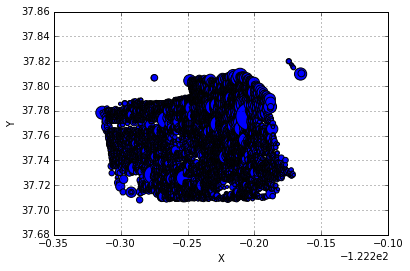

In [36]:
# Let's freq first, then set the size of the dot by the number of crimes
loc_freq = data_clean.groupby(by=['X','Y']).size().reset_index()
print "The number of observations to plot is condensed from {:,} to {:,}.".format(len(data_clean),len(loc_freq))

loc_freq.plot(kind='scatter', x='X', y='Y', s=10*np.sqrt(loc_freq[0]))
#Not as helpful as I would have hoped, just too much going on w/out limiting the data.

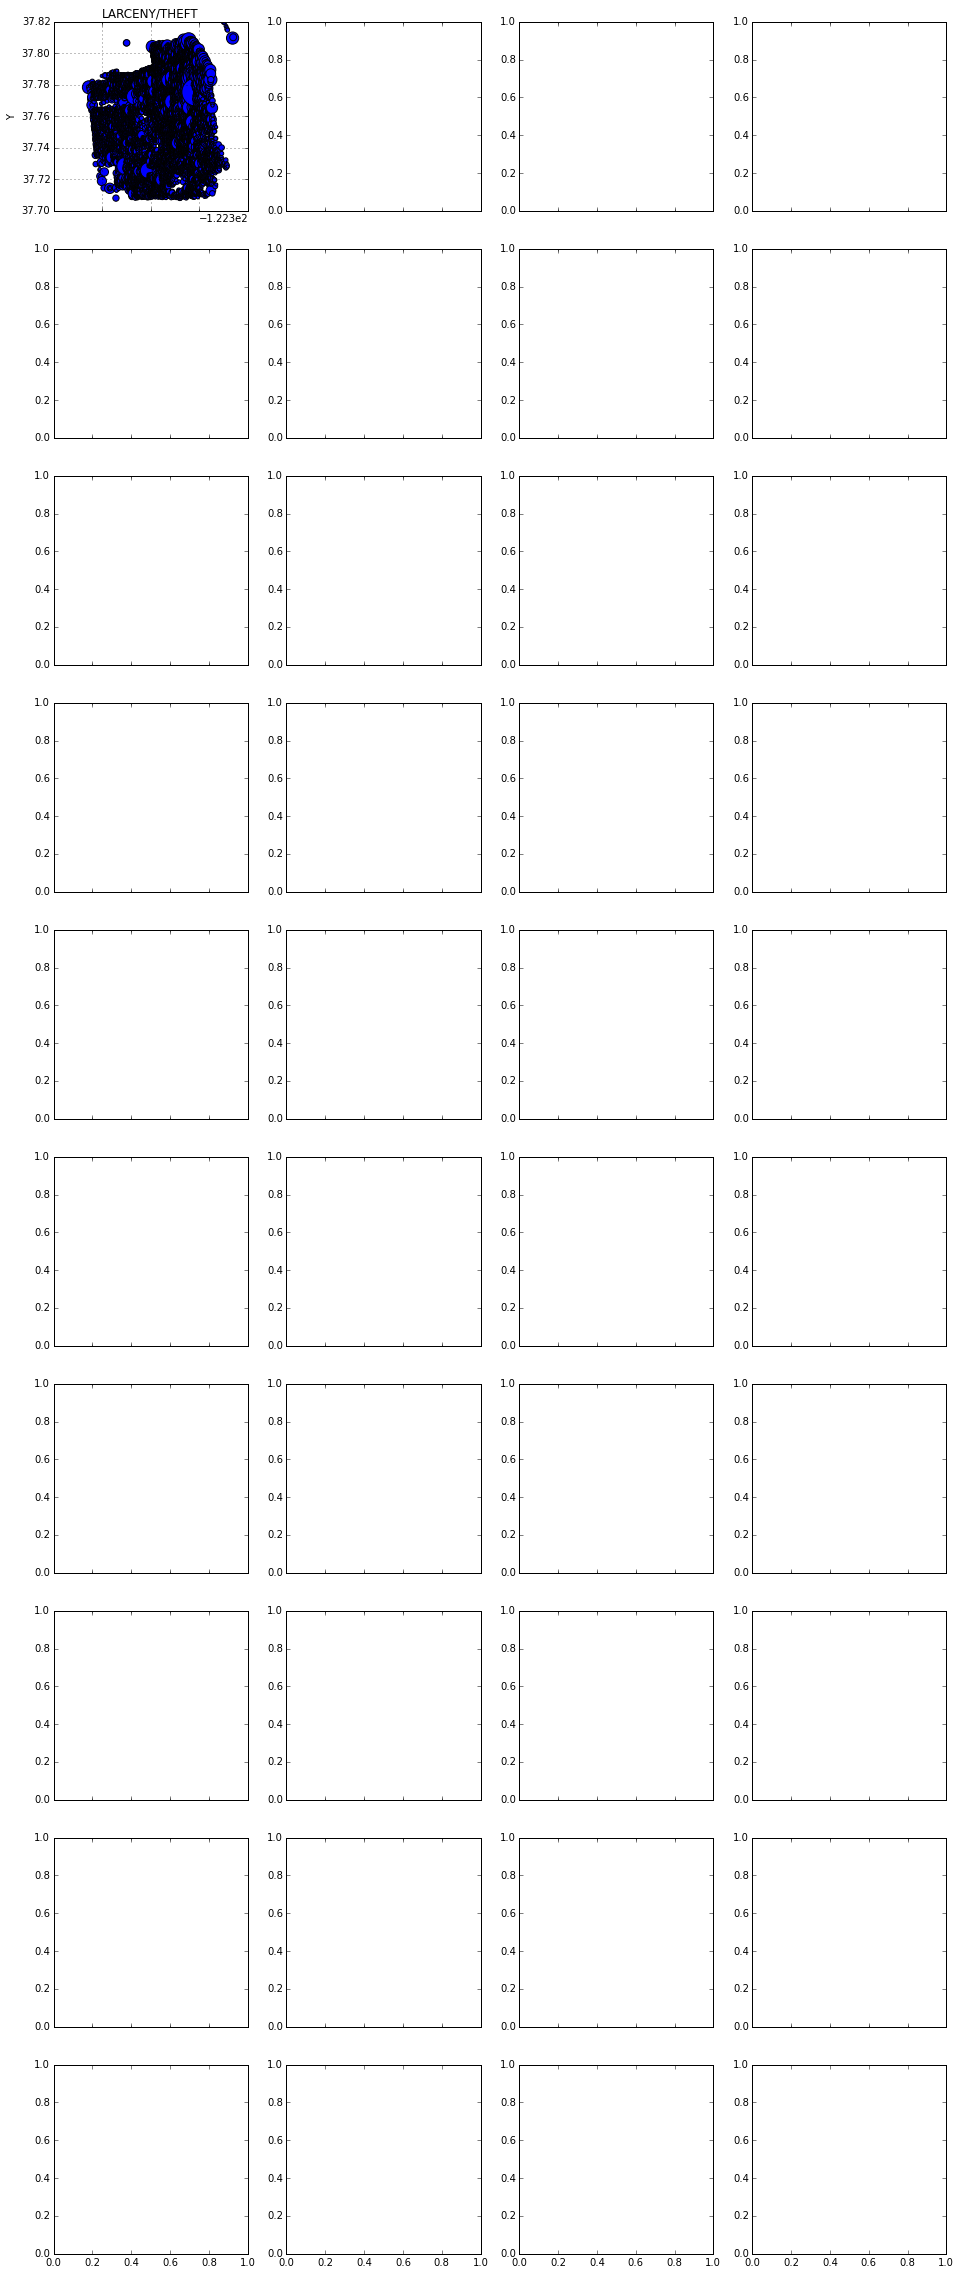

In [37]:
# Let's create one plot per category...
loc_freq = data_clean.groupby(by=['Category','X','Y']).size().reset_index()
fig, axes = plt.subplots(nrows=10, ncols=4, figsize=(16, 40))
for i,var in enumerate(loc_freq.Category.value_counts().index):
    loc_freq[loc_freq.Category == var].plot(kind='scatter', x='X', y='Y', s=10*np.sqrt(loc_freq[0]), 
                                            ax=axes[i/4, i%4], title=var, xlim=(-122.55,-122.35), ylim=(37.7,37.82))
    if i%4 != 0:
        axes[i/4, i%4].get_yaxis().set_visible(False)

# I don't see much of a pattern. Maybe sometimes a little.

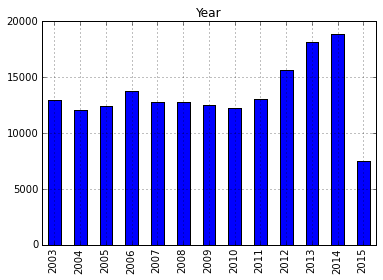

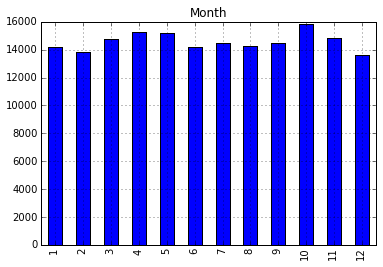

In [38]:
# Let's look at entries over time...
data_clean['Dates'].groupby(data_clean.Dates.dt.year).count().plot(kind="bar", title="Year")
plt.show()
data_clean['Dates'].groupby(data_clean.Dates.dt.month).count().plot(kind="bar", title="Month")
plt.show()

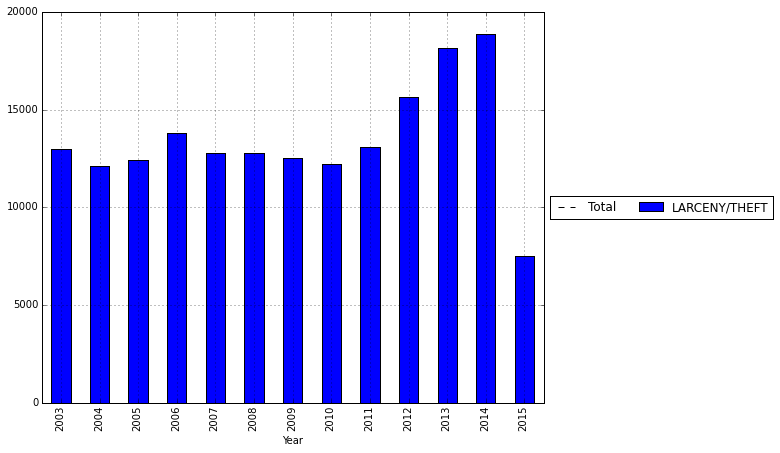

In [39]:
# Look at categories over time
data['Count'] = 1

sub_data = data[['Count','Year','Category']]
category_group = sub_data.groupby(['Year','Category']).sum()
plot = category_group.unstack().plot(kind='bar', stacked=True, figsize=(9, 7), legend=False)

# Prepare legend
leg = np.sort(pd.unique(data.Category))
leg = np.insert(leg, 0, "Total")

plot.legend(leg, loc='center left', bbox_to_anchor=(1, 0.5),ncol=2)

# Many categories remain generally stable. Larceny increases, while Vehicle Theft falls.
# Note the legend while repeating colors is in reverse order from the figure